In [1]:
import torch as t
from torch.distributions import Normal
import torch.nn as nn
import bayesfunc as bf
import matplotlib.pyplot as plt

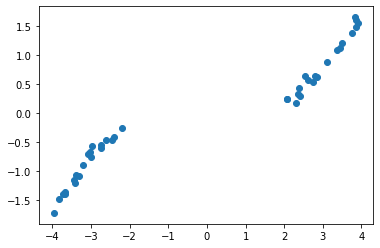

In [2]:
# Generate data
in_features = 1
out_features = 1
train_batch = 40

t.manual_seed(0)
X = t.zeros(train_batch, in_features)
X[:int(train_batch/2), :] = t.rand(int(train_batch/2), in_features)*2. - 4.
X[int(train_batch/2):, :] = t.rand(int(train_batch/2), in_features)*2. + 2.
y = X**3. + 3*t.randn(train_batch, in_features)

#Rescale the outputs to have unit variance
scale = y.std()
y = y/scale

dtype=t.float64
device="cpu"

X = X.to(dtype=dtype, device=device)
y = y.to(dtype=dtype, device=device)

plt.scatter(X, y)

In [3]:
def train(net):
    opt = t.optim.Adam(net.parameters(), lr=0.05)
    samples = 10
    for i in range(2500):
        opt.zero_grad()
        output, logpq, _ = bf.propagate(net, X.expand(samples, -1, -1))
        ll = Normal(output, 3/scale).log_prob(y).sum(-1).mean(-1)
        assert ll.shape == (samples,)
        assert logpq.shape == (samples,)
        elbo = ll + min(i/500., 1.)*logpq/train_batch
        (-elbo.mean()).backward()
        opt.step()
    print(elbo.mean().item())
        
def plot(net):
    with t.no_grad():
        xs = t.linspace(-6,6,100)[:, None].to(device=device, dtype=dtype)
        print(xs.shape)
        #set sample=100, so we draw 100 different functions
        ys, _, _ = bf.propagate(net, xs.expand(100, -1, -1))
        mean_ys = ys.mean(0)
        std_ys = ys.std(0)
        plt.fill_between(xs[:, 0], mean_ys[:, 0]-2*std_ys[:, 0], mean_ys[:, 0]+2*std_ys[:, 0], alpha=0.5)
        plt.plot(xs, mean_ys)
        plt.scatter(X, y, c='r')



Mean-field variational inference
======

-6.424556489174215
torch.Size([100, 1])


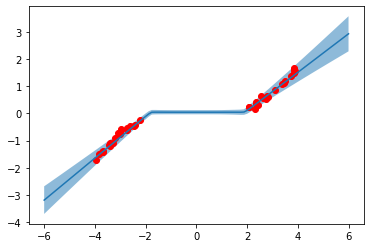

In [4]:
net = nn.Sequential(
    bf.FactorisedLinear(in_features=1, out_features=50, bias=True),
    nn.ReLU(),
    bf.FactorisedLinear(in_features=50, out_features=50, bias=True),
    nn.ReLU(),
    bf.FactorisedLinear(in_features=50, out_features=1, bias=True)
)
net = net.to(device=device, dtype=dtype)
train(net)
plot(net)

Local-inducing with Bayesian neural networks
=======

-8.189561409306961
torch.Size([100, 1])


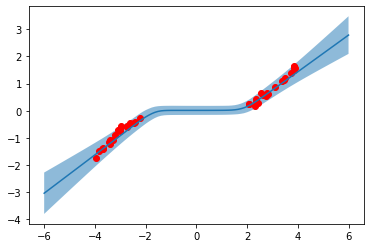

In [5]:
net = nn.Sequential(
    bf.LILinear(in_features=1, out_features=50, bias=True),
    nn.ReLU(),
    bf.LILinear(in_features=50, out_features=50, bias=True, full_prec=True),
    nn.ReLU(),
    bf.LILinear(in_features=50, out_features=1, bias=True, full_prec=True)
)
net = net.to(device=device, dtype=dtype)
train(net)
plot(net)

Global-inducing with Bayesian neural networks
=====

-0.20042732063344024
torch.Size([100, 1])


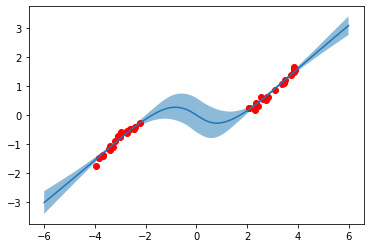

In [6]:
inducing_batch=40
net = nn.Sequential(
    bf.GILinear(in_features=1, out_features=50, inducing_batch=inducing_batch, bias=True),
    nn.ReLU(),
    bf.GILinear(in_features=50, out_features=50, inducing_batch=inducing_batch, bias=True),
    nn.ReLU(),
    bf.GILinear(in_features=50, out_features=1, inducing_batch=inducing_batch, bias=True, full_prec=True)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_data=t.linspace(-4, 4, inducing_batch)[:, None])
net = net.to(device=device, dtype=dtype)
train(net)
plot(net)

Local-inducing with Gaussian processes
========

-2.0435744505993303
torch.Size([100, 1])


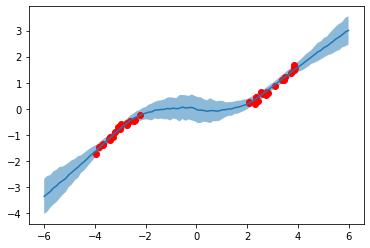

In [7]:
t.manual_seed(0)
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.KernelLIGP(in_features=2, out_features=10, inducing_batch=inducing_batch, kernel=bf.ReluKernelFeatures(inducing_batch=inducing_batch)),
    bf.KernelLIGP(in_features=10, out_features=1, inducing_batch=inducing_batch, kernel=bf.ReluKernelFeatures(inducing_batch=inducing_batch))
)
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)

Global-inducing deep Gaussian processes
=====

0.493026735713104
torch.Size([100, 1])


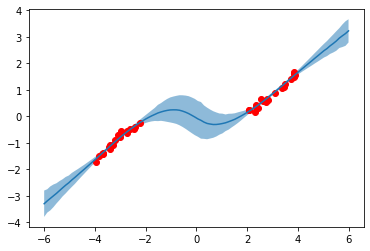

In [8]:
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.ReluKernelFeatures(inducing_batch=inducing_batch),
    bf.GIGP(out_features=10, inducing_batch=inducing_batch),
    bf.ReluKernelFeatures(inducing_batch=inducing_batch),
    bf.GIGP(out_features=1, inducing_batch=inducing_batch)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_data=t.linspace(-5, 5, inducing_batch)[:, None])
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)

Inducing NNGP
===============

0.49998838540504587
torch.Size([100, 1])


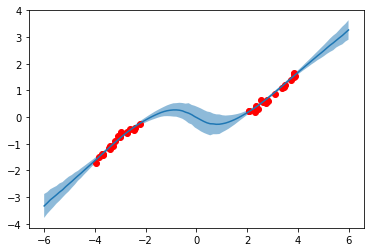

In [9]:
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.FeaturesToKernel(inducing_batch=inducing_batch),
    bf.ReluKernelGram(),
    bf.ReluKernelGram(),
    bf.GIGP(out_features=1, inducing_batch=inducing_batch)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_shape=(inducing_batch, 1))
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)

Deep kernel processes
==========

0.5060419468378595
torch.Size([100, 1])


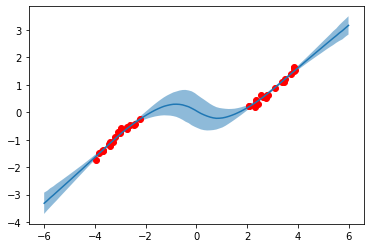

In [10]:
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.FeaturesToKernel(inducing_batch=inducing_batch),
    bf.ReluKernelGram(),    
    bf.IWLayer(inducing_batch),
    bf.ReluKernelGram(),
    bf.GIGP(out_features=1, inducing_batch=inducing_batch)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_data=t.linspace(-5, 5, inducing_batch)[:, None])
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)

## Deep Wishart processes

0.49218252436239374
torch.Size([100, 1])


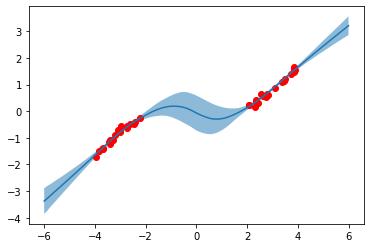

In [4]:
inducing_batch = 40
net = nn.Sequential(
    bf.BiasFeature(),
    bf.FeaturesToKernel(inducing_batch=inducing_batch),
    bf.ReluKernelGram(),    
    bf.WishartLayer(inducing_batch, nu=10),
    bf.ReluKernelGram(),
    bf.GIGP(out_features=1, inducing_batch=inducing_batch)
)
net = bf.InducingWrapper(net, inducing_batch=inducing_batch, inducing_data=t.linspace(-5, 5, inducing_batch)[:, None])
net = net.to(device=device, dtype=dtype)

train(net)
plot(net)